In [ ]:
!pip install inflect

In [1]:
import pandas as pd
import numpy as np
import inflect
import neural_lib as nl
import matplotlib.pyplot as plt

from frozendict import frozendict
from sklearn.utils import shuffle
from ucimlrepo import fetch_ucirepo 
from fcapy.visualizer import LineVizNx
from fcapy.context import FormalContext
from fcapy.lattice import ConceptLattice
from sklearn.model_selection import train_test_split
plt.rcParams['figure.facecolor'] = (1,1,1,1)

In [2]:
import warnings
warnings.filterwarnings('ignore')

## FIRST DATASET

In [117]:
from ucimlrepo import fetch_ucirepo 

wine = fetch_ucirepo(id=109) 
X = wine.data.features 
y = wine.data.targets 

In [118]:
indices_to_drop = y[y == 3].dropna().index

X = X.drop(indices_to_drop)
y = y.drop(indices_to_drop)
y['class'] = y['class'] == 2

In [119]:
combined_df = pd.concat([X, y], axis=1)
shuffled_df = shuffle(combined_df)
selected_df = shuffled_df.iloc[:129]
features_wine = selected_df.drop(columns=['class'], axis=1)
target_wine = selected_df['class']

In [120]:
features_wine

,Alcohol,Malicacid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,0D280_0D315_of_diluted_wines,Proline
103,11.82,1.72,1.88,19.5,86,2.50,1.64,0.37,1.42,2.06,0.94,2.44,415
123,13.05,5.80,2.13,21.5,86,2.62,2.65,0.30,2.01,2.60,0.73,3.10,380
113,11.41,0.74,2.50,21.0,88,2.48,2.01,0.42,1.44,3.08,1.10,2.31,434
85,12.67,0.98,2.24,18.0,99,2.20,1.94,0.30,1.46,2.62,1.23,3.16,450
99,12.29,3.17,2.21,18.0,88,2.85,2.99,0.45,2.81,2.30,1.42,2.83,406
...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,12.08,1.13,2.51,24.0,78,2.00,1.58,0.40,1.40,2.20,1.31,2.72,630
87,11.65,1.67,2.62,26.0,88,1.92,1.61,0.40,1.34,2.60,1.36,3.21,562
25,13.05,2.05,3.22,25.0,124,2.63,2.68,0.47,1.92,3.58,1.13,3.20,830
42,13.88,1.89,2.59,15.0,101,3.25,3.56,0.17,1.70,5.43,0.88,3.56,1095


In [121]:
target_wine.value_counts()

True     70
False    59
Name: class, dtype: int64

In [124]:
features_wine = features_wine.drop(columns = ['Nonflavanoid_phenols', 'Malicacid', 'Ash', 'Alcalinity_of_ash'])

In [125]:
p = inflect.engine()

custom_index = [p.number_to_words(i+1).capitalize() for i in range(len(features_wine))]
features_wine.index = custom_index
target_wine.index = custom_index

In [126]:
for col in features_wine.columns:
    median_val = features_wine[col].median()
    features_wine.loc[:, col] = features_wine[col] >= median_val

X_train, X_test, y_train, y_test = train_test_split(features_wine, target_wine, test_size=0.3, random_state=42)

In [127]:
K_train = FormalContext.from_pandas(X_train)
K_train

FormalContext (90 objects, 9 attributes, 425 connections)
                            |Alcohol|Magnesium|Total_phenols|Flavanoids|Proanthocyanins|Color_intensity|Hue|0D280_0D315_of_diluted_wines|Proline|
Twenty-three                |       |        X|             |          |               |               |   |                            |       |
Forty-five                  |       |         |             |          |               |               |   |                           X|       |
Sixty-six                   |      X|        X|            X|         X|              X|              X|  X|                            |      X|
Ninety-seven                |      X|        X|            X|         X|              X|              X|   |                           X|      X|
Thirty-one                  |      X|        X|            X|         X|              X|              X|  X|                            |      X|
Sixty-three                 |       |         |            X|     

In [128]:
L = ConceptLattice.from_context(K_train, is_monotone=True)
len(L)

230

In [129]:
from sklearn.metrics import f1_score

for c in L:
    y_preds = np.zeros(K_train.n_objects)
    y_preds[list(c.extent_i)] = 1
    f1 = f1_score(y_train, y_preds, average='weighted')

    # Create a new frozendict with the updated values
    updated_measures = dict(c.measures)
    updated_measures['f1_score'] = f1
    c.measures = frozendict(updated_measures)

In [130]:
best_concepts = list(L.measures['f1_score'].argsort()[::-1][:7])

In [131]:
cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))

In [132]:
vis = LineVizNx(node_label_font_size=14, node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes))+'\n\n')

In [133]:
descr = {'smooth', 'green', 'oval'}

traced = cn.trace_description(descr, include_targets=False)

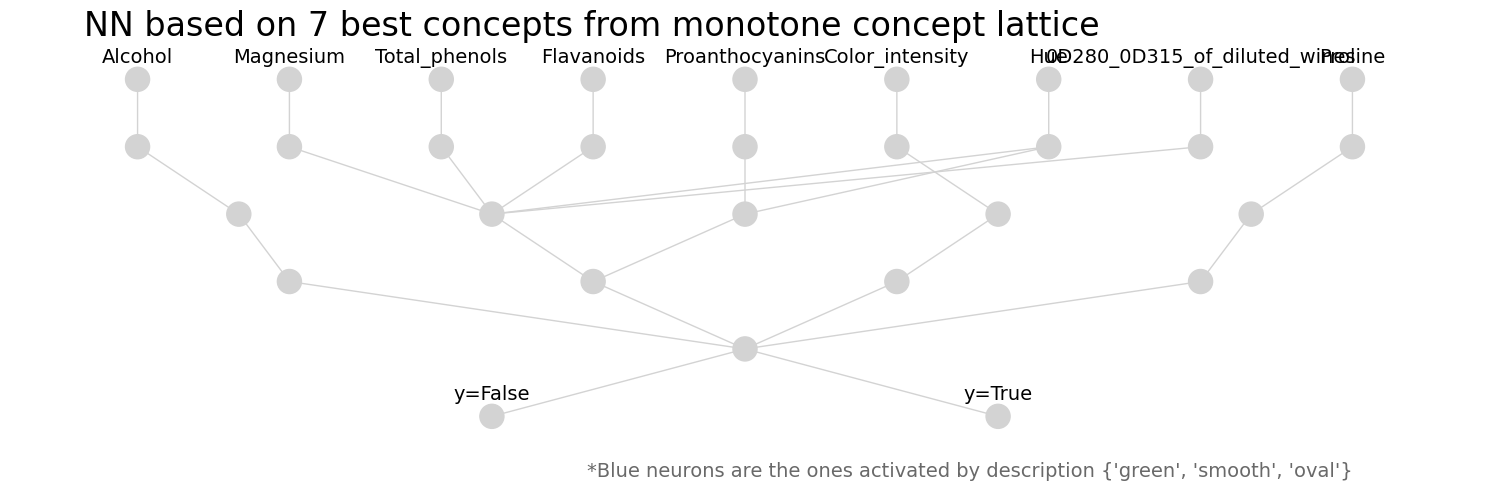

In [134]:
fig, ax = plt.subplots(figsize=(15,5))

vis.draw_poset(
    cn.poset, ax=ax,
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    node_color=['darkblue' if el_i in traced else 'lightgray' for el_i in range(len(cn.poset))]
)
plt.title(f'NN based on 7 best concepts from monotone concept lattice', loc='left', x=0.05, size=24)

plt.text(max(vis.mover.posx), min(vis.mover.posy)-0.3, f'*Blue neurons are the ones activated by description {descr}', fontsize=14, ha='right', color='dimgray')

plt.subplots_adjust()
plt.tight_layout()
plt.show()

In [135]:
X_train.shape

(90, 9)

In [136]:
y_train.value_counts()

True     49
False    41
Name: class, dtype: int64

In [137]:
cn.fit(X_train, y_train)

In [138]:
print('Class prediction', cn.predict(X_test).numpy())
print('Class prediction with probabilities', cn.predict_proba(X_test).detach().numpy())
print('True class', y_test.values)
print('f1 score', f1_score(y_test.values, cn.predict(X_test).numpy()))

Class prediction [0 0 0 1 0 1 0 1 1 0 1 0 1 1 0 1 0 1 0 0 1 0 1 1 1 0 0 1 0 1 0 1 0 1 1 0 1
 1 0]
Class prediction with probabilities [[0.9988732  0.00112676]
 [0.9988732  0.00112676]
 [0.9988732  0.00112676]
 [0.01917828 0.98082167]
 [0.9988732  0.00112676]
 [0.01917828 0.98082167]
 [0.9988732  0.00112676]
 [0.01917828 0.98082167]
 [0.01917828 0.98082167]
 [0.9988732  0.00112676]
 [0.01917828 0.98082167]
 [0.9988732  0.00112676]
 [0.01917828 0.98082167]
 [0.01917828 0.98082167]
 [0.9988732  0.00112676]
 [0.01917828 0.98082167]
 [0.9988732  0.00112676]
 [0.01917828 0.98082167]
 [0.9988732  0.00112676]
 [0.9988732  0.00112676]
 [0.01917828 0.98082167]
 [0.9988732  0.00112676]
 [0.01917828 0.98082167]
 [0.01917828 0.98082167]
 [0.01917828 0.98082167]
 [0.9988732  0.00112676]
 [0.9988732  0.00112676]
 [0.01917828 0.98082167]
 [0.9988732  0.00112676]
 [0.01917828 0.98082167]
 [0.9988732  0.00112676]
 [0.01917828 0.98082167]
 [0.9988732  0.00112676]
 [0.01917828 0.98082167]
 [0.01917828 0.9

In [139]:
edge_weights = cn.edge_weights_from_network()

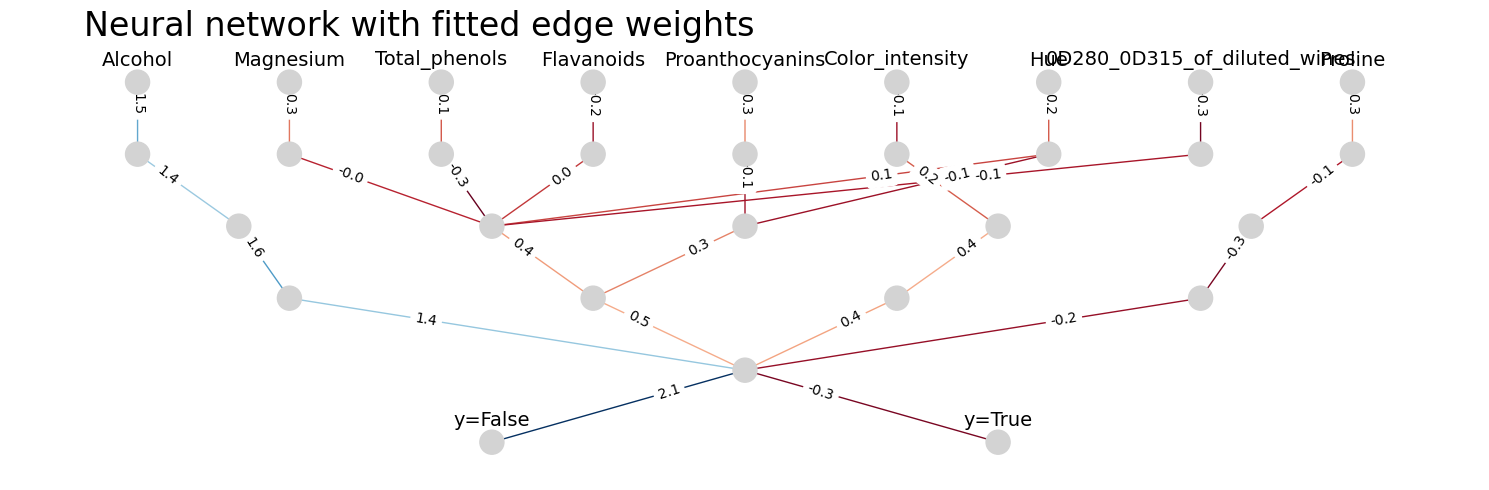

In [140]:
import networkx as nx

fig, ax = plt.subplots(figsize=(15,5))

vis.draw_poset(
    cn.poset, ax=ax,
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    edge_color=[edge_weights[edge] for edge in cn.poset.to_networkx().edges],
    edge_cmap=plt.cm.RdBu,
)
nx.draw_networkx_edge_labels(cn.poset.to_networkx(), vis.mover.pos, {k: f"{v:.1f}" for k,v in edge_weights.items()}, label_pos=0.7)

plt.title('Neural network with fitted edge weights', size=24, x=0.05, loc='left')
plt.tight_layout()
plt.subplots_adjust()
plt.savefig('fitted_network.png')
plt.show()

## SECOND DATASET

In [235]:
wine_quality = fetch_ucirepo(id=186) 

X = wine_quality.data.features 
y = wine_quality.data.targets 

In [236]:
p = inflect.engine()

custom_index = [p.number_to_words(i+1).capitalize() for i in range(len(X))]
X.index = custom_index
y.index = custom_index

In [237]:
for col in X.columns:
    median_val = X[col].median()
    X.loc[:, col] = X[col] >= median_val

median_val = y['quality'].median()
y.loc[:, 'quality'] = y['quality'] >= median_val

In [238]:
combined_df = pd.concat([X, y], axis=1)
shuffled_df = shuffle(combined_df)
selected_df = shuffled_df.iloc[:4200]
X = selected_df.drop(columns=['quality'], axis=1)
y = selected_df['quality']

In [239]:
X = X.drop(columns = ['free_sulfur_dioxide', 'pH', 'sulphates'])

In [240]:
y.value_counts()

True     2676
False    1524
Name: quality, dtype: int64

In [241]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [242]:
K_train = FormalContext.from_pandas(X_train)
K_train

FormalContext (2940 objects, 8 attributes, 12019 connections)
                                            |fixed_acidity|volatile_acidity|citric_acid|residual_sugar|chlorides|total_sulfur_dioxide|density|alcohol|
One thousand, five hundred and seventy-five |             |               X|          X|             X|        X|                    |      X|      X|
Five thousand, six hundred and ninety-five  |             |               X|           |             X|        X|                    |      X|       |
Nine hundred and eighty-two                 |            X|               X|           |              |        X|                    |      X|       |
Eight hundred and six                       |            X|                |          X|              |        X|                    |       |      X|
One thousand, one hundred and seventy-one   |            X|               X|          X|              |        X|                    |      X|      X|
Three hundred and fifteen       

In [243]:
L = ConceptLattice.from_context(K_train, is_monotone=True)
len(L)

240

In [244]:
for c in L:
    y_preds = np.zeros(K_train.n_objects)
    y_preds[list(c.extent_i)] = 1
    f1 = f1_score(y_train, y_preds, average='weighted')

    # Create a new frozendict with the updated values
    updated_measures = dict(c.measures)
    updated_measures['f1_score'] = f1
    c.measures = frozendict(updated_measures)

In [245]:
best_concepts = list(L.measures['f1_score'].argsort()[::-1][:5])

In [246]:
cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))

In [247]:
vis = LineVizNx(node_label_font_size=14, node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes))+'\n\n')

In [248]:
descr = {'smooth', 'green', 'oval'}

traced = cn.trace_description(descr, include_targets=False)

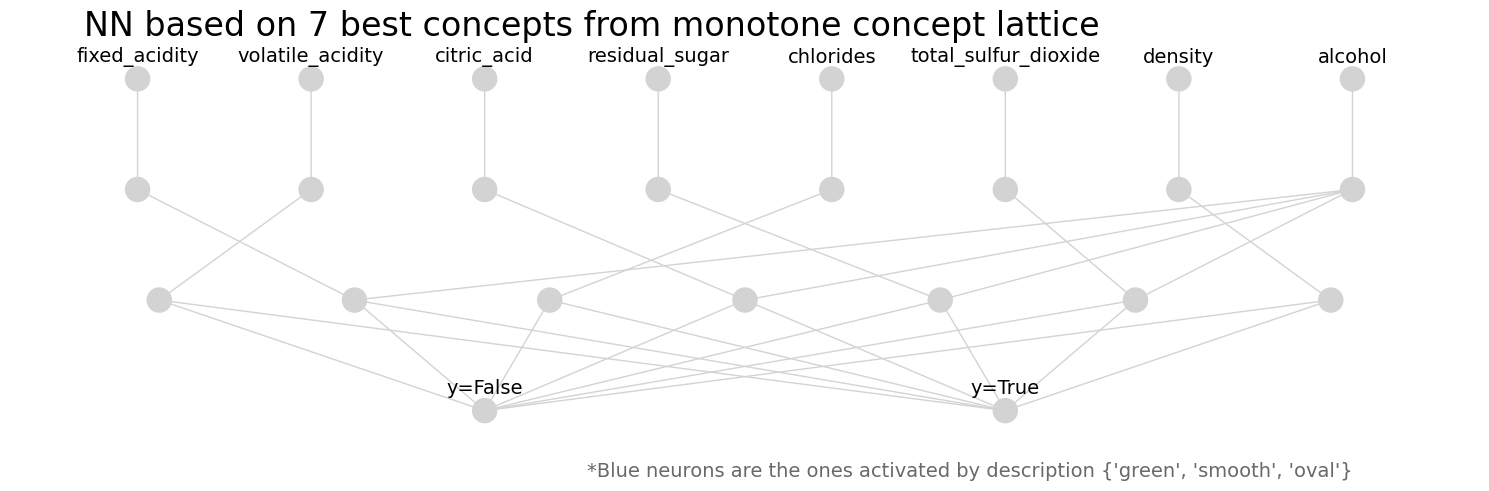

In [249]:
fig, ax = plt.subplots(figsize=(15,5))

vis.draw_poset(
    cn.poset, ax=ax,
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    node_color=['darkblue' if el_i in traced else 'lightgray' for el_i in range(len(cn.poset))]
)
plt.title(f'NN based on 7 best concepts from monotone concept lattice', loc='left', x=0.05, size=24)

plt.text(max(vis.mover.posx), min(vis.mover.posy)-0.3, f'*Blue neurons are the ones activated by description {descr}', fontsize=14, ha='right', color='dimgray')

plt.subplots_adjust()
plt.tight_layout()
plt.show()

In [250]:
cn.fit(X_train, y_train)

In [251]:
print('Class prediction', cn.predict(X_test).numpy())
print('Class prediction with probabilities', cn.predict_proba(X_test).detach().numpy())
print('True class', y_test.values)
print('f1 score', f1_score(y_test.values, cn.predict(X_test).numpy()))

Class prediction [1 1 0 ... 1 1 1]
Class prediction with probabilities [[0.00156531 0.9984347 ]
 [0.3538364  0.6461636 ]
 [0.83894366 0.16105631]
 ...
 [0.0015653  0.9984347 ]
 [0.26609674 0.7339032 ]
 [0.02205897 0.97794104]]
True class [ True  True False ... False False False]
f1 score 0.7995378393991912


In [252]:
edge_weights = cn.edge_weights_from_network()

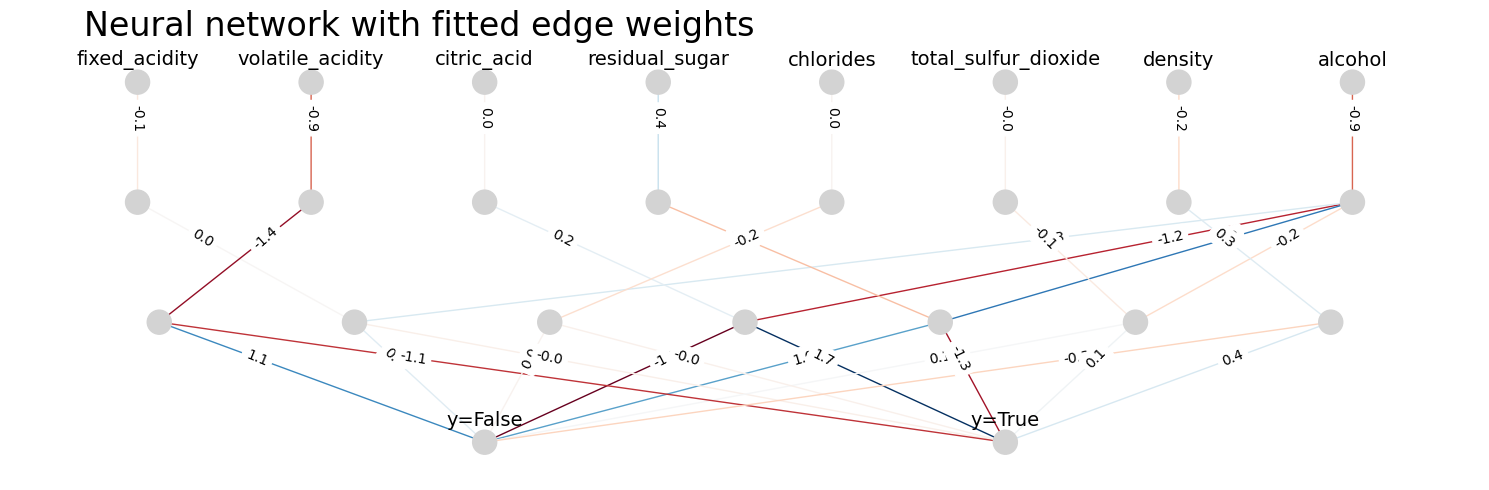

In [253]:
fig, ax = plt.subplots(figsize=(15,5))

vis.draw_poset(
    cn.poset, ax=ax,
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    edge_color=[edge_weights[edge] for edge in cn.poset.to_networkx().edges],
    edge_cmap=plt.cm.RdBu,
)
nx.draw_networkx_edge_labels(cn1.poset.to_networkx(), vis.mover.pos, {k: f"{v:.1f}" for k,v in edge_weights.items()}, label_pos=0.7)

plt.title('Neural network with fitted edge weights', size=24, x=0.05, loc='left')
plt.tight_layout()
plt.subplots_adjust()
plt.savefig('fitted_network.png')
plt.show()

## THIRD DATASET

In [334]:
adult = fetch_ucirepo(id=2) 
X = adult.data.features 
y = adult.data.targets 

In [335]:
X['workclass'] = X['workclass'].fillna('?')
X['occupation'] = X['occupation'].fillna('?')
X['native-country'] = X['native-country'].fillna('?')

In [336]:
y['income'] = y['income'] == '<=50K'

def convert_to_bool(column):
    if column.dtype == 'object':
        mode = column.mode()[0]
        return column == mode
    else:
        median = column.median()
        return column >= median

X = X.iloc[:, 1:].apply(convert_to_bool)

In [337]:
X = X.drop(columns = ['race', 'marital-status'])

In [338]:
combined_df = pd.concat([X, y], axis=1)
shuffled_df = shuffle(combined_df)
selected_df = shuffled_df.iloc[:60000]
X = selected_df.drop(columns=['income'], axis=1)
y = selected_df['income']

In [339]:
p = inflect.engine()

custom_index = [p.number_to_words(i+1).capitalize() for i in range(len(X))]
X.index = custom_index
y.index = custom_index

In [340]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [341]:
K_train = FormalContext.from_pandas(X_train)
K_train

FormalContext (34189 objects, 11 attributes, 236685 connections)
                                                   |workclass|fnlwgt|education|education-num|occupation|...|sex|capital-gain|capital-loss|hours-per-week|native-country|
Forty-two thousand, three hundred and ninety-three |        X|     X|         |            X|         X|...|   |           X|           X|             X|             X|
Fourteen thousand, six hundred and twenty-four     |        X|     X|         |            X|          |...|  X|           X|           X|             X|             X|
Twenty-seven thousand, four hundred and twelve     |        X|     X|        X|             |          |...|  X|           X|           X|             X|             X|
One thousand, two hundred and eighty-nine          |        X|     X|         |            X|          |...|  X|           X|           X|             X|             X|
Seven thousand and seventy-nine                    |        X|      |         |           

In [345]:
L = ConceptLattice.from_context(K_train, is_monotone=True)
len(L)

381

In [346]:
for c in L:
    y_preds = np.zeros(K_train.n_objects)
    y_preds[list(c.extent_i)] = 1
    f1 = f1_score(y_train, y_preds, average='weighted')
    
    updated_measures = dict(c.measures)
    updated_measures['f1_score'] = f1
    c.measures = frozendict(updated_measures)

In [347]:
best_concepts = list(L.measures['f1_score'].argsort()[::-1][:10])
cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))
vis = LineVizNx(node_label_font_size=14, node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes))+'\n\n')

descr = {'smooth', 'green', 'oval'}

traced = cn.trace_description(descr, include_targets=False)

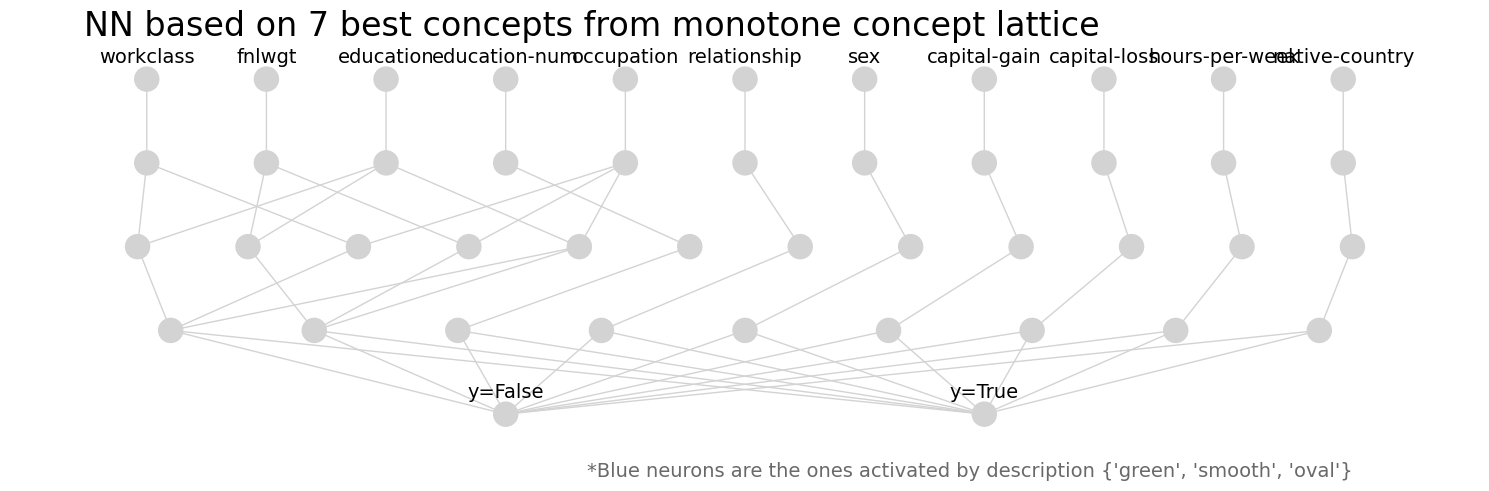

In [348]:
fig, ax = plt.subplots(figsize=(15,5))

vis.draw_poset(
    cn.poset, ax=ax,
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    node_color=['darkblue' if el_i in traced else 'lightgray' for el_i in range(len(cn.poset))]
)
plt.title(f'NN based on 7 best concepts from monotone concept lattice', loc='left', x=0.05, size=24)

plt.text(max(vis.mover.posx), min(vis.mover.posy)-0.3, f'*Blue neurons are the ones activated by description {descr}', fontsize=14, ha='right', color='dimgray')

plt.subplots_adjust()
plt.tight_layout()
plt.show()

In [349]:
cn.fit(X_train, y_train)

In [350]:
print('Class prediction', cn.predict(X_test).numpy())
print('Class prediction with probabilities', cn.predict_proba(X_test).detach().numpy())
print('True class', y_test.values)
print('f1 score', f1_score(y_test.values, cn.predict(X_test).numpy()))

Class prediction [1 1 1 ... 1 1 1]
Class prediction with probabilities [[0.48370677 0.5162932 ]
 [0.48370677 0.5162932 ]
 [0.48370677 0.5162932 ]
 ...
 [0.48370677 0.5162932 ]
 [0.48370677 0.5162932 ]
 [0.48370677 0.5162932 ]]
True class [False False  True ... False  True  True]
f1 score 0.6679090909090908


In [351]:
edge_weights = cn.edge_weights_from_network()

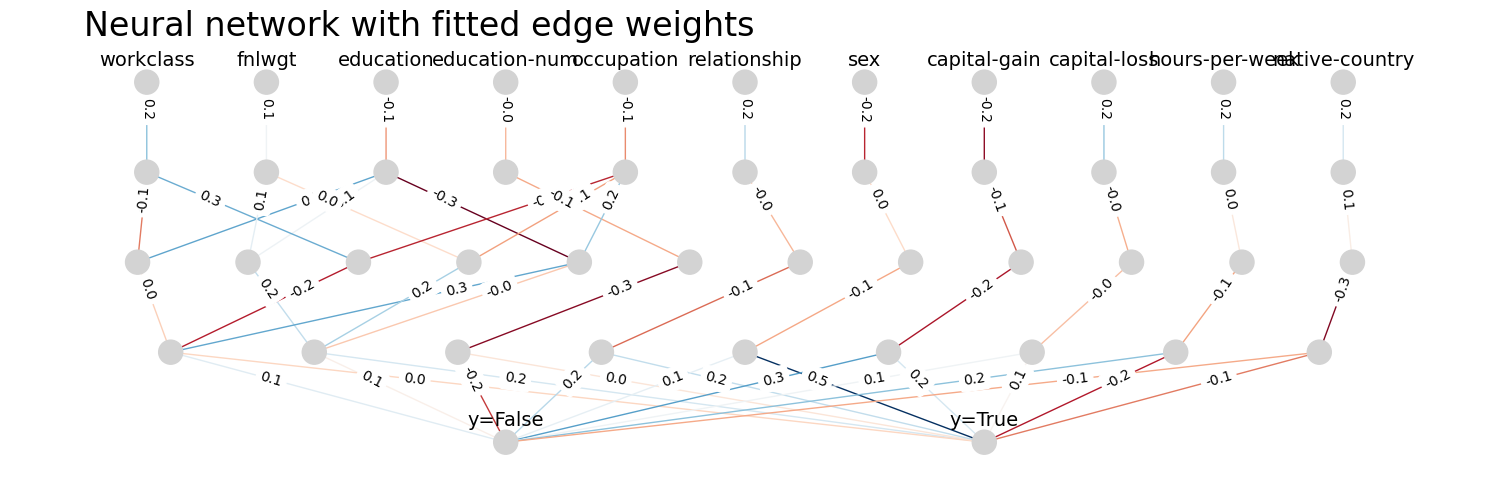

In [352]:
fig, ax = plt.subplots(figsize=(15,5))

vis.draw_poset(
    cn.poset, ax=ax,
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    edge_color=[edge_weights[edge] for edge in cn.poset.to_networkx().edges],
    edge_cmap=plt.cm.RdBu,
)
nx.draw_networkx_edge_labels(cn1.poset.to_networkx(), vis.mover.pos, {k: f"{v:.1f}" for k,v in edge_weights.items()}, label_pos=0.7)

plt.title('Neural network with fitted edge weights', size=24, x=0.05, loc='left')
plt.tight_layout()
plt.subplots_adjust()
plt.savefig('fitted_network.png')
plt.show()